In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'vgg16:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F6302%2F9896%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240615%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240615T104505Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D3c5d643d64af6cf62aa7a66b30417651278753f155a0827b4cb498360f80b6e1fd8e18d6e100890b84cab1af6dcb1eebb42a9e74dbc2401bb590eda84a8d5ad3bbaef7c01e0709699fda463675f57c28f243ac5168cf1d1b11547f1496a93de6f4592ca4e8764253d230da3c3d0411a6148a511d992a08e10863ed7165d688375738b29b093ec191829d2264d641853ecb07f728bea69f29d30f246e40c154ebf728cd2003e164dff374d8c54e93ceeb802049bab2e77629df6f7c125f20a0e83f7b651659bfcbe3254277ad0a1e0ef03421fa665ce991ed2b0f1edbe256befb99f7544a8442654f974fb9d3c2e20b577ddcf96dae65a29b82086aeebb0e4052,chest-xray-pneumonia:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F17810%2F23812%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240615%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240615T104505Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Da982bbefce2361e6aef1fdb31b8d6ebe98a5bcfe4b364cfa65cdc4fefbda522b3466abf6af6bceb9daf02b8dd1db93c46b6e0f908ac1f3027c90091bcc2c841622a38a53601707f17787adf872fcc5a2891562df1f0860e4174362a8c145a8815b1522bc89ece2f441e5d587e9a67545084443ee7e6510a708a5d8030f2b1a2940175dd92f3792efb6afef6e5c3f27dceb65318ecf1a2a2cefefd0613d6a5b63df54cc999eb63f63c3d7c233f59ee71c420e32a39f41c863fe9f503db96be9c6c57b0e1c5c5e13d344145379a57d4ed9ede1a91ab431990803b289a8e8d4f5eea481c4c7e6ba99259cbeaf1db52de44fb66680370301ce401e9092039c7af24a,pneumonia-lungs:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2726343%2F4712653%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240615%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240615T104505Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D2b88112991c0725b664df8c1f0e569a54a06f7993eb24981fc3b6cf1a3641afeb15472bd8ee8d8226e1af31b7f74ea5f91d0196afcda7f918f43152e55701a19ae5acdc72f9e500cea583e295218fd175b08e1821f5773371fcc7fadd66785ed3d66b237fe6411e2e7779138e9c84b895b027089857f616b816bfede0352145239ad4915da695b6549c1933717b1de8437a1c5a45a415a3c50445c270734d51d6decb75b9f2398fdf8b33fae8b83a417ffd449590263449a7aa6961b6d9e463f047026d55e6c7a6f9f16db11ddf8bd5da0f235be7284281c1d52e49661a6236549ae0f9f1cf53d94a3c591e4dcee1a2cb4e567a89ecd0e2478e930af024fb2e2,pneumonia-lung-image-for-test:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2730180%2F4718780%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240615%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240615T104505Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D05f2750d41902523dc16f7c30f4fa62fe350c2e881a9f683b41d0d1df67e24208f552e25ef7b817fc77620f99742336ef9976509574def360da976e0dc081e5a5e353c905f6e93640039d604464db980c168e4e9efb9b4550d0fd16e22677ed36b1200b15befaf0caa9ba9fdfc1c27670df0d4bdc6cfbdbf7d8d2ea8edf0d176c2a17bb29eb5623e01b236b8d217db321d4d2117cd45c80a04b2c016e13baccecfaaf0ddf23945890ce50c6e88faf293810f6479ebe50935ae6063d94bb7918c5a5b3e4c1029adbf37d7ea9f81b96f23d03482794b0d5c865241e5ce806348f10262100a3fd91a2993b7b6bbac9923802575a064b3c15b626a06c7e76a5cf687,test-pne:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5168447%2F8631740%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240615%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240615T104506Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dae4902f31f2dd0b199c5fb6504cee50fc99fd7cc7ac4359d48315f337b4eed05c26ab29e571c419b330690bd2641842519d4e48c2260e26fd6a6fd406c93b7d6c134e5b51b5aed4637ed9c5308e9eb80c6aa8ea64cdfa1fff171a0dda33b89ca1e1e72bd02be6660cbc93d25e55d498d5b2d3050d9dea7616c395dad5dc06a16079fb98411c879d91ee27a6adfa766f35d710965b63b9be3f2238e67c0f2426d39f5543d9b0c007d9b576f55d52a1448d1256671c9007193c8d3d75c36a52f61505b6b6ad5a4f9ffe298051269215bee4f84a4d0c0fa2c2b05454506ba50ce82bf2111623e1b24240d2f8614c87cc4c294c6e15a4c9c0a0f4849b8cd264f54f5'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


<div style="border:px solid blue; border-radius:1px; padding:px">
    <img src="https://news.mit.edu/sites/default/files/styles/news_article__image_gallery/public/images/202206/MIT-Pneumonia-Sensor-01-press_0.jpg?itok=pY607Gyu" width="100%">
</div>

<p style="font-size:15px;color:#000000;font-weight:500;"> What is the pneumonia? </p>

Pneumonia is an infection that inflames the air sacs in one or both lungs. The air sacs may fill with fluid or pus, causing cough with phlegm or pus, fever, chills, and difficulty breathing. A variety of organisms, including bacteria, viruses and fungi, can cause pneumonia

<p style="font-size:15px;color:#000000;font-weight:500;"> What is the main cause of pneumonia? </p>

Viruses that infect your lungs and airways can cause pneumonia. The flu (influenza virus) and the common cold (rhinovirus) are the most common causes of viral pneumonia in adults. Respiratory syncytial virus is the most common cause of viral pneumonia in young children

<p style="font-size:15px;color:#000000;font-weight:500;"> For more and detailed information: </p>

https://en.wikipedia.org/wiki/Pneumonia

In [ ]:
import platform

version = platform.python_version()
print(version)

3.7.12


In [ ]:
#!pip install -U git+https://github.com/albumentations-team/albumentations
#!pip install np_utils

In [ ]:
%%time

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import cv2, os, random
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.offline import init_notebook_mode, plot, iplot

#____________________________________________________________

import glob
import tensorflow
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, BatchNormalization
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from tensorflow.keras.models import Sequential
from mlxtend.plotting import plot_confusion_matrix
from tensorflow.keras.preprocessing import image
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.model_selection import train_test_split
\

#____________________________________________________________

from tqdm.notebook import tqdm
from termcolor import colored
import albumentations as A

#____________________________________________________________

from warnings import filterwarnings
filterwarnings("ignore")

from sklearn import set_config
set_config(print_changed_only = False)
directory = "../input/chest-xray-pneumonia/chest_xray/"

#____________________________________________________________

print(colored("Required libraries were succesfully imported...", color = "green", attrs = ["bold", "dark"]))

Required libraries were succesfully imported...
CPU times: user 3.23 s, sys: 631 ms, total: 3.87 s
Wall time: 3.47 s


In [ ]:
import sys
print(sys.version)

3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:53) 
[GCC 9.4.0]


In [ ]:
pip list

Package                               Version                Editable project location
------------------------------------- ---------------------- -------------------------
absl-py                               0.15.0
accelerate                            0.12.0
access                                1.1.8
affine                                2.3.1
aiobotocore                           2.4.0
aiohttp                               3.8.1
aioitertools                          0.11.0
aiosignal                             1.2.0
albumentations                        1.3.0
alembic                               1.8.1
allennlp                              2.10.1
altair                                4.2.0
annoy                                 1.17.1
ansiwrap                              0.8.4
anyio                                 3.6.1
apache-beam                           2.40.0
aplus                                 0.11.0
appdirs                               1.4.4
argon2-cffi                

### Check GPU

In [ ]:
print(tensorflow.config.list_physical_devices("GPU"))

print("________________________________________________")

print(tensorflow.test.is_gpu_available(cuda_only = False, min_cuda_compute_capability = None))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
________________________________________________
True


In [ ]:
"""
path = "/kaggle/input/chest-xray-pneumonia/chest_xray"
for pat in os.listdir(path):
    nwpath = os.path.join(path,pat)
    print(pat)
    print(len(os.listdir(nwpath)))
    for item in os.listdir(nwpath):
        print(f"{item}:")
        print(len(os.listdir(os.path.join(nwpath,item))))
"""

'\npath = "/kaggle/input/chest-xray-pneumonia/chest_xray"\nfor pat in os.listdir(path):\n    nwpath = os.path.join(path,pat)\n    print(pat)\n    print(len(os.listdir(nwpath)))\n    for item in os.listdir(nwpath):\n        print(f"{item}:")\n        print(len(os.listdir(os.path.join(nwpath,item))))\n'

In [ ]:
path = "/kaggle/input/chest-xray-pneumonia/chest_xray/test"
print(f"the main folder has {len(os.listdir(path))} folders: {os.listdir(path)}")
folders = os.listdir(path)
print(f"The {folders[0]} has:")
pxx = os.path.join(path,folders[0])
print(len(os.listdir(pxx)))

the main folder has 2 folders: ['PNEUMONIA', 'NORMAL']
The PNEUMONIA has:
390


In [ ]:
path = "/kaggle/input/chest-xray-pneumonia/chest_xray"
print(os.listdir(path))

['chest_xray', '__MACOSX', 'val', 'test', 'train']


In [ ]:
print("Current tensorflow version == {}".format(tensorflow. __version__))

Current tensorflow version == 2.6.4


<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#4A1810; font-family:sans-serif;color:#FFFFFF;font-size:130%;text-align:center;border-radius:55px 1px;">Load the datasets 🔺️</p>

In [ ]:
%%time

train_df = glob.glob("../input/chest-xray-pneumonia/chest_xray/train/**/*.jpeg")
test_df = glob.glob("../input/chest-xray-pneumonia/chest_xray/test/**/*.jpeg")
validation_df = glob.glob("../input/chest-xray-pneumonia/chest_xray/val/**/*.jpeg")

print(colored("The datasets were succesfully loaded...", color = "green", attrs = ["bold", "dark"]))

The datasets were succesfully loaded...
CPU times: user 23 ms, sys: 2.81 ms, total: 25.8 ms
Wall time: 29.9 ms


#### <span style='background:#4A1810;color:#ffffff;'> Look at train and test sets </span>

In [ ]:
train_df[:5], test_df[:5]

(['../input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1180_virus_2010.jpeg',
  '../input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1230_virus_2081.jpeg',
  '../input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1513_virus_2632.jpeg',
  '../input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person124_virus_238.jpeg',
  '../input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person746_virus_1369.jpeg'],
 ['../input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person1676_virus_2892.jpeg',
  '../input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person1650_virus_2852.jpeg',
  '../input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person22_virus_55.jpeg',
  '../input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person122_bacteria_582.jpeg',
  '../input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person85_bacteria_417.jpeg'])

<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#4A1810; font-family:sans-serif;color:#FFFFFF;font-size:130%;text-align:center;border-radius:55px 1px;">Do some data exploration 🔺️</p>

#### <span style='background:#4A1810;color:#ffffff;'> How many images are in each dataset? </span>

In [ ]:
print("There is {} images in the training dataset".format(len(train_df)))
print("There is {} images in the test dataset".format(len(test_df)))
print("There is {} images in the validation dataset".format(len(validation_df)))

There is 5216 images in the training dataset
There is 624 images in the test dataset
There is 16 images in the validation dataset


#### <span style='background:#4A1810;color:#ffffff;'> How many of the pictures are of pneumonic lungs and how many are of normal lungs </span>

In [ ]:
datasets, pneumonia_lung, normal_lung = ["train", "test", "val"], [], []

for i in datasets:
    path = os.path.join(directory, i)
    normal = glob.glob(os.path.join(path, "NORMAL/*.jpeg"))
    pneumonia = glob.glob(os.path.join(path, "PNEUMONIA/*.jpeg"))
    normal_lung.extend(normal), pneumonia_lung.extend(pneumonia)

print("The number of pneumonia images is {}".format(len(pneumonia_lung)))
print("The number of non-pneumonia images is {}".format(len(normal_lung)))

The number of pneumonia images is 4273
The number of non-pneumonia images is 1583


#### <span style='background:#4A1810;color:#ffffff;'> Shuffle the images </span>

In [ ]:
random.shuffle(normal_lung)
random.shuffle(pneumonia_lung)
images = normal_lung[:50] + pneumonia_lung[:50]
images[:10]

['../input/chest-xray-pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-0649-0001.jpeg',
 '../input/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0234-0001.jpeg',
 '../input/chest-xray-pneumonia/chest_xray/test/NORMAL/NORMAL2-IM-0349-0001.jpeg',
 '../input/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0552-0001.jpeg',
 '../input/chest-xray-pneumonia/chest_xray/test/NORMAL/IM-0105-0001.jpeg',
 '../input/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0613-0001.jpeg',
 '../input/chest-xray-pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-0946-0001.jpeg',
 '../input/chest-xray-pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-0825-0001.jpeg',
 '../input/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0605-0001.jpeg',
 '../input/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0713-0001.jpeg']

#### <span style='background:#4A1810;color:#ffffff;'> View the images in X-ray format </span>

<mark>X-ray imaging creates pictures of the inside of a body. The images show the parts of a body in different shades of black and white. This is because different tissues absorb different amounts of radiation. Calcium in bones absorbs x-rays the most, so bones look white</mark>

NORMAL


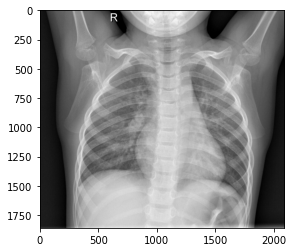

In [ ]:
normal_lung_image = load_img("/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0115-0001.jpeg")
print("NORMAL")
plt.imshow(normal_lung_image)
plt.show()

PNEUMONIA


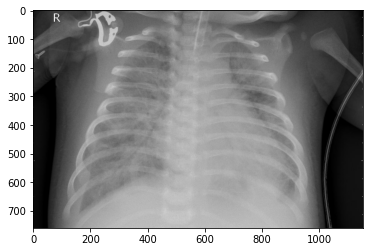

In [ ]:
normal_lung_image = load_img("/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1000_bacteria_2931.jpeg")
print("PNEUMONIA")
plt.imshow(normal_lung_image)
plt.show()

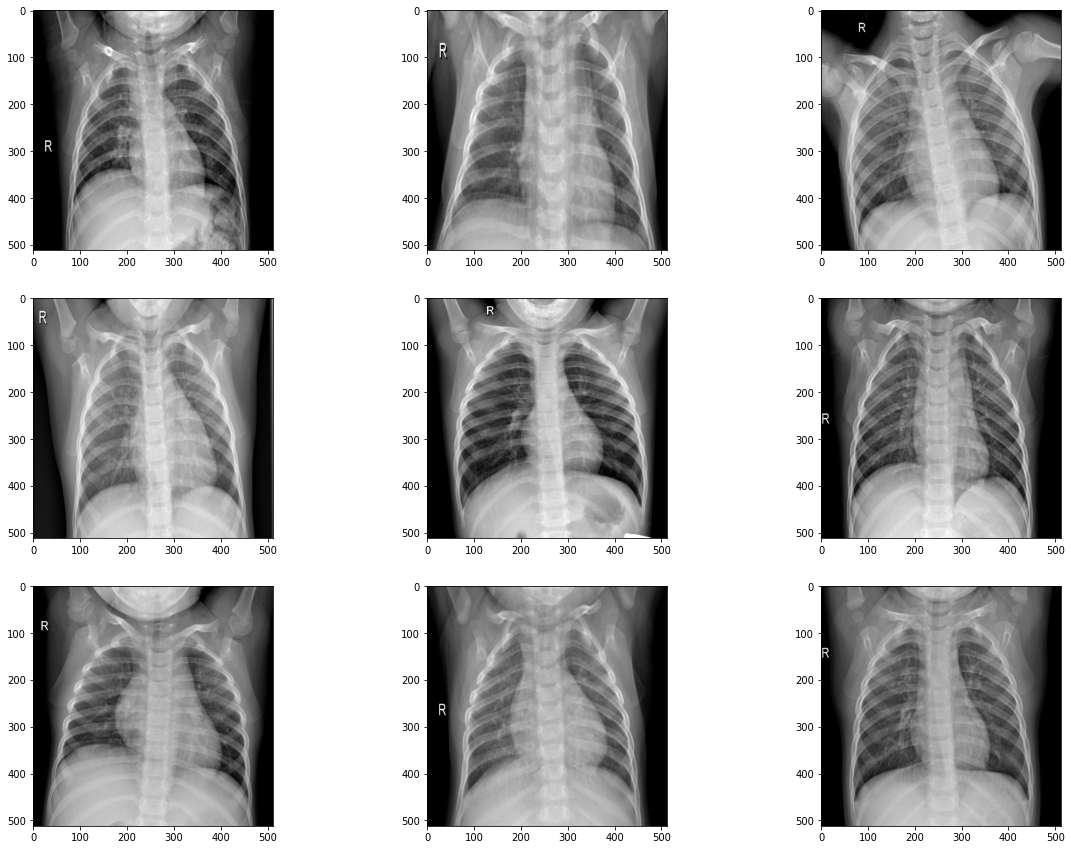

In [ ]:
fig = plt.figure(figsize = (20, 15))
columns, rows = 3, 3
for i in range(1, 10):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)

#### <span style='background:#4A1810;color:#ffffff;'> Image erosion </span>

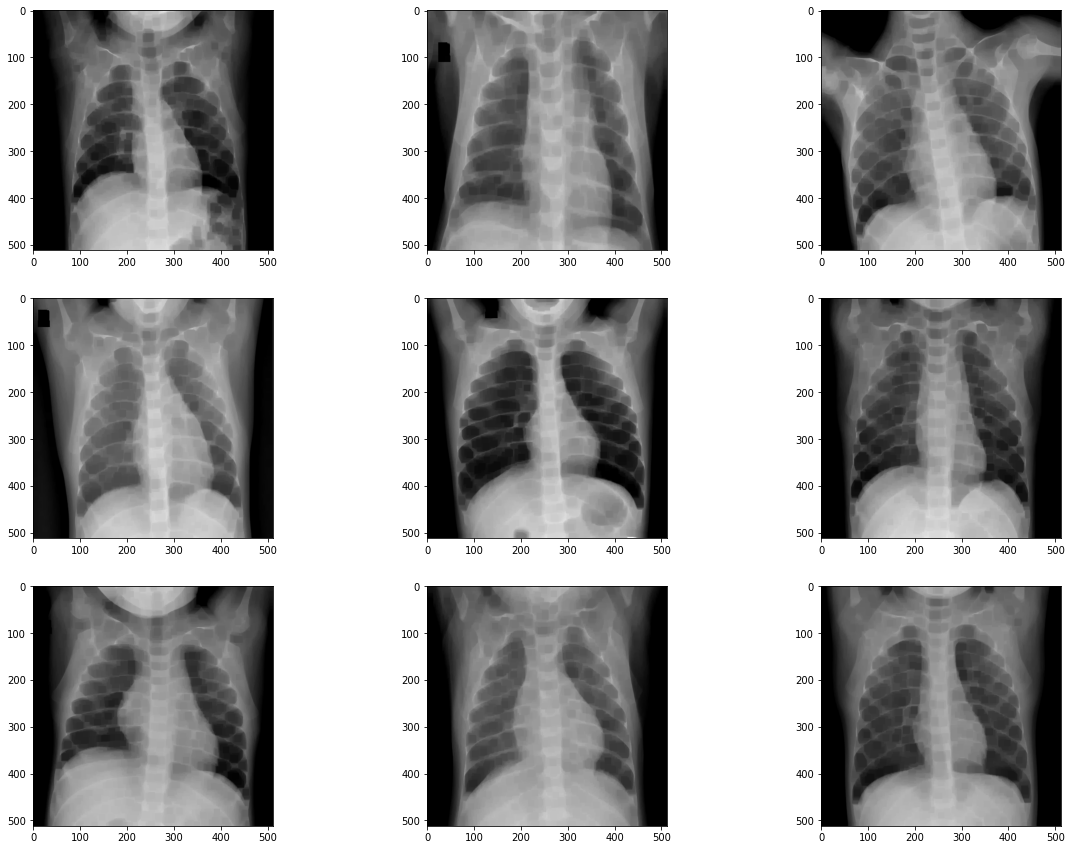

In [ ]:
fig = plt.figure(figsize = (20, 15))
columns, rows = 3, 3
for i in range(1, 10):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    kernel = np.ones((5, 5), np.uint8)
    image_erosion = cv2.erode(img, kernel, iterations=3)
    fig.add_subplot(rows, columns, i)
    plt.imshow(image_erosion)

#### <span style='background:#4A1810;color:#ffffff;'> Image dilation </span>

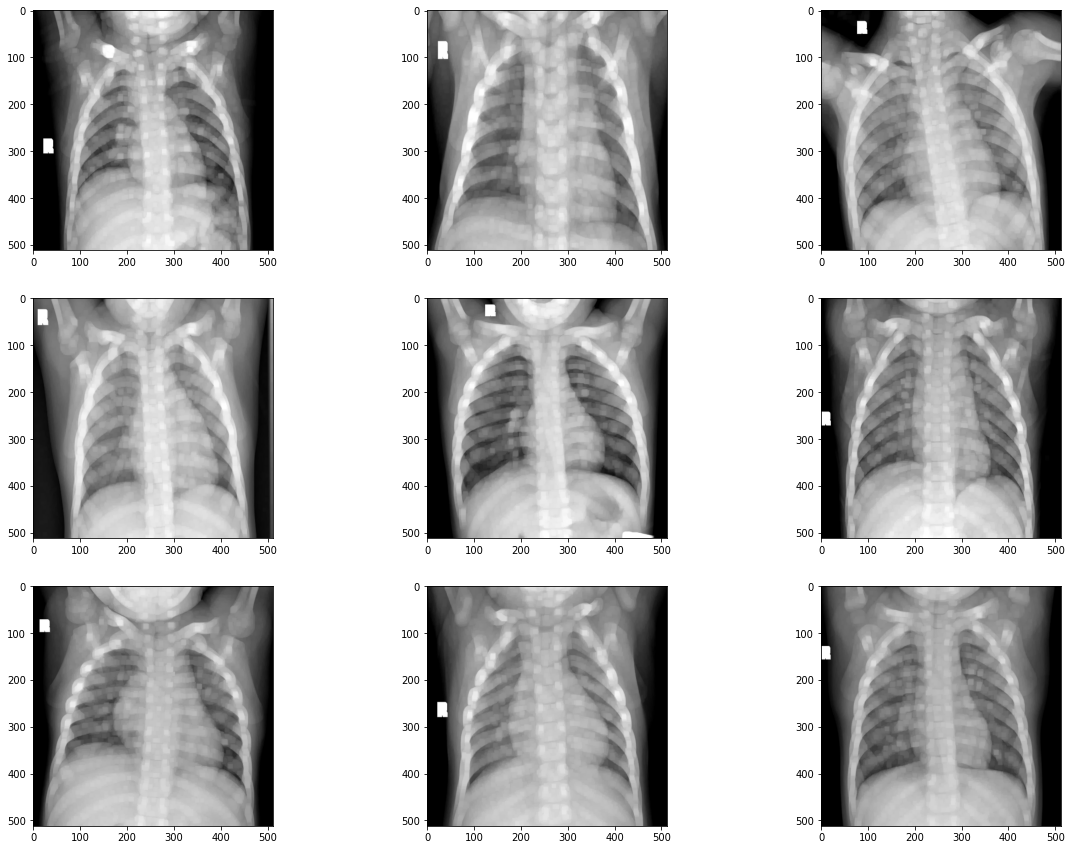

In [ ]:
fig = plt.figure(figsize = (20, 15))
columns, rows = 3, 3

for i in range(1, 10):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    kernel = np.ones((5, 5), np.uint8)
    image_dilation = cv2.dilate(img, kernel, iterations = 2)
    fig.add_subplot(rows, columns, i)
    plt.imshow(image_dilation)

#### <span style='background:#4A1810;color:#ffffff;'> Convert the images to greyscale and then apply Gaussian blur to them </span>

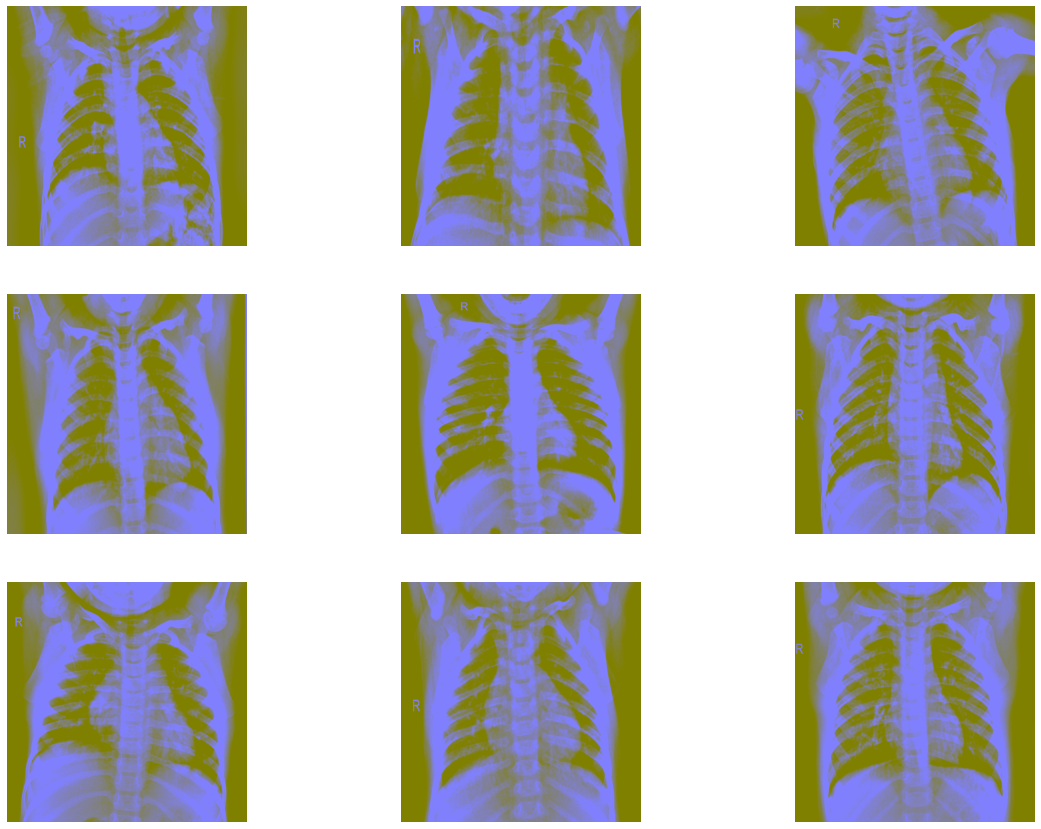

In [ ]:
fig = plt.figure(figsize = (20, 15))
columns, rows = 3, 3

for i in range(1, 10):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img = cv2.addWeighted (img, 4, cv2.GaussianBlur(img, (0, 0), 512/10), -4, 128)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis(False)

#### <span style='background:#4A1810;color:#ffffff;'> Canny edge detection: </span>

<mark>Canny edge detection is a technique to extract useful structural information from different vision objects and dramatically reduce the amount of data to be processed. It has been widely applied in various computer vision systems</mark>

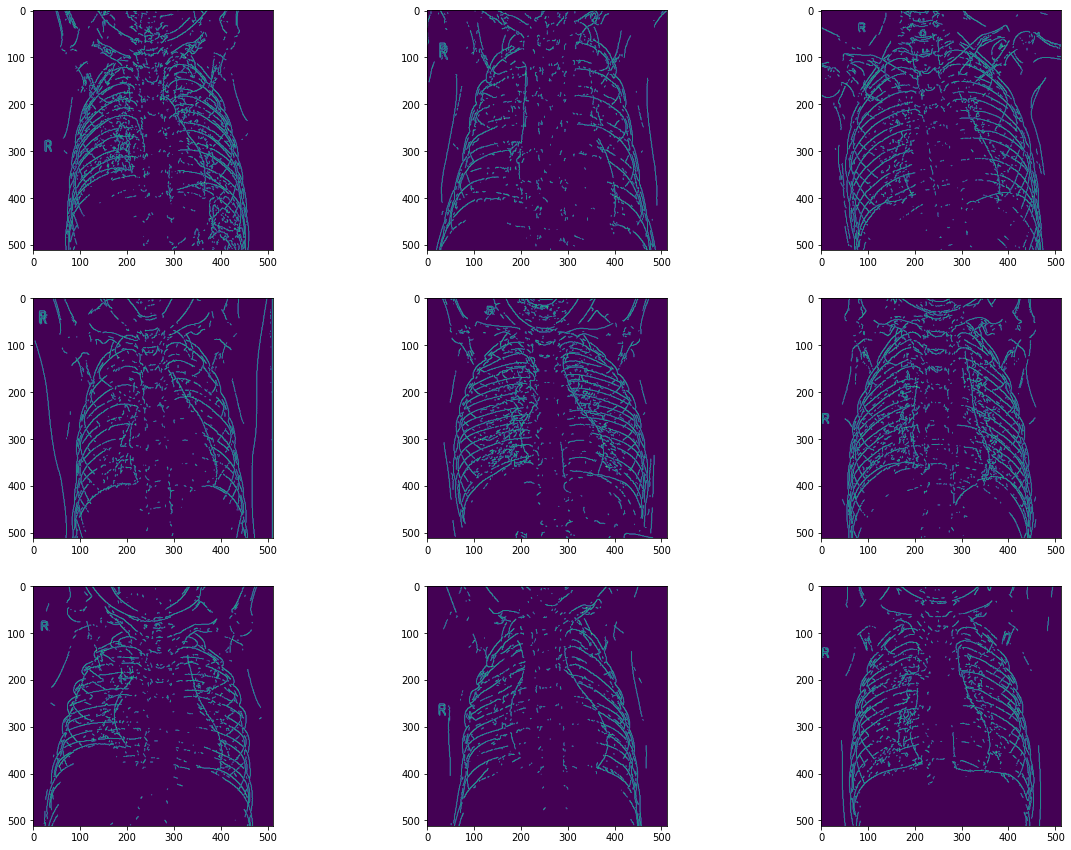

In [ ]:
fig = plt.figure(figsize = (20, 15))
columns, rows = 3, 3

for i in range(1, 10):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    detected_edges = cv2.Canny(img, 80, 100)
    fig.add_subplot(rows, columns, i)
    plt.imshow(detected_edges)

<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#4A1810; font-family:sans-serif;color:#FFFFFF;font-size:130%;text-align:center;border-radius:55px 1px;">Build deep learning models 🔺️</p>

In [ ]:
train_dir = "../input/chest-xray-pneumonia/chest_xray/train"
test_dir = "../input/chest-xray-pneumonia/chest_xray/test"
validation_dir = "../input/chest-xray-pneumonia/chest_xray/val"

In [ ]:
import os
len(os.listdir(train_dir))

2

Loading data with ImageDataGenerator

In [ ]:
"""

%%time

train_datagen = ImageDataGenerator(
            rescale = 1/255.,
            horizontal_flip = True,
            vertical_flip = True,
            rotation_range = 0.3,
            zca_whitening = True,
            width_shift_range = 0.25,
            height_shift_range = 0.25,
            channel_shift_range = 0.35,
            shear_range = 0.2,
            zoom_range = 0.4)

val_test_datagen = ImageDataGenerator(rescale = 1./255)

train_set = train_datagen.flow_from_directory(train_dir, class_mode = "binary", batch_size = 16, target_size = (224, 224))
validation_set = val_test_datagen.flow_from_directory(validation_dir, class_mode = "binary", batch_size = 16, target_size = (224, 224))
test_set = val_test_datagen.flow_from_directory(test_dir, class_mode = "binary", batch_size = 16, target_size = (224, 224))

"""

'\n\n%%time\n\ntrain_datagen = ImageDataGenerator(\n            rescale = 1/255.,\n            horizontal_flip = True,\n            vertical_flip = True,\n            rotation_range = 0.3,\n            zca_whitening = True,\n            width_shift_range = 0.25,\n            height_shift_range = 0.25,\n            channel_shift_range = 0.35,\n            shear_range = 0.2,\n            zoom_range = 0.4)\n\nval_test_datagen = ImageDataGenerator(rescale = 1./255)\n\ntrain_set = train_datagen.flow_from_directory(train_dir, class_mode = "binary", batch_size = 16, target_size = (224, 224))\nvalidation_set = val_test_datagen.flow_from_directory(validation_dir, class_mode = "binary", batch_size = 16, target_size = (224, 224))\ntest_set = val_test_datagen.flow_from_directory(test_dir, class_mode = "binary", batch_size = 16, target_size = (224, 224))\n\n'

In [ ]:
'''
AUTOTUNE = tensorflow.data.experimental.AUTOTUNE

train_set = train_set.cache().prefetch(buffer_size = AUTOTUNE)
test_set = test_set.cache().prefetch(buffer_size = AUTOTUNE)
validation_set = validation_set.cache().prefetch(buffer_size = AUTOTUNE)
'''
pass

#We wil Load Data in a different way (Manually) so we can balance the dataset:

In [ ]:
uniq_labels = sorted(os.listdir(train_dir))
#print(uniq_labels)
lab_dic={}
for v,k in enumerate(uniq_labels):
    lab_dic[k.lower()] = v

print(lab_dic)

def file_gen(directory):
    images = []
    labels = []
    #directory = train_dir2
    train_files = sorted(os.listdir(directory))
    print(train_files)
    for label in train_files:
        print(label)
        for idx, image_nm in enumerate(os.listdir(directory + "/" + label)):
            #print(idx)
            if idx in range(5000):
               filepath = directory + "/" + label + "/" + image_nm
               #print(image_nm)
               #print(idx)
               try:
                    img = cv2.resize(cv2.imread(filepath), (224,224))
               except:
                    continue
               images.append(img)
               #plt.imshow(image)
               tag = lab_dic[label.lower()]
               labels.append(tag)
               #print(tag)

    return images, labels

def file_gen_(directory, label):
    images = []
    labels = []
    #directory = train_dir2
    #train_files = sorted(os.listdir(directory))
    #print(train_files)
    #print(label)
    for idx, image_nm in enumerate(os.listdir(directory)):
            #print(idx)
            if idx in range(5000):
               filepath = directory + "/" + image_nm
               #print(image_nm)
               #print(idx)
               try:
                    img = cv2.resize(cv2.imread(filepath), (224,224))
               except:
                    continue
               images.append(img)
               #plt.imshow(image)
               tag = lab_dic[label.lower()]
               labels.append(tag)
               #print(tag)

    return images, labels

{'normal': 0, 'pneumonia': 1}


In [ ]:
#create a data list
train_data = []
train_label = []

train_data_f = []
train_label_f = []

In [ ]:
#read the train data separately

pn_dir = train_dir + "/" + "PNEUMONIA"
nm_dir = train_dir + "/" + "NORMAL"
images_1, labels_1 = file_gen_(pn_dir, "PNEUMONIA")
images_2, labels_2 = file_gen_(nm_dir, "NORMAL")

#images_, labels_ = file_gen(train_dir)
print("done")

done


In [ ]:
#read the test data
images_t, labels_t = file_gen(test_dir)

#read the validation dataset
images_v, labels_v = file_gen(validation_dir)

print("done")

['NORMAL', 'PNEUMONIA']
NORMAL
PNEUMONIA
['NORMAL', 'PNEUMONIA']
NORMAL
PNEUMONIA
done


In [ ]:
print(f"Total pneumonia images loaded: {len(images_1)}")
print(f"Total Normal images loaded: {len(images_2)}")

#read the data and only select 1341 of the pneumonia image
#so the number of images in both classes can be the same.

train_data.extend(images_1[:1341])
train_data.extend(images_2)
train_label.extend(labels_1[:1341])
train_label.extend(labels_2)

#The full data
train_data_f.extend(images_1)
train_data_f.extend(images_2)
train_label_f.extend(labels_1)
train_label_f.extend(labels_2)

train_data_arr = np.asarray(train_data)
train_label_arr = np.asarray(train_label)

train_data_arr_f = np.asarray(train_data_f)
train_label_arr_f = np.asarray(train_label_f)

Total pneumonia images loaded: 3875
Total Normal images loaded: 1341


In [ ]:
print(f"train data array: {train_data_arr.shape}")
print(f"train data label array: {train_label_arr.shape}")

train data array: (2682, 224, 224, 3)
train data label array: (2682,)


In [ ]:
print(f"Total test images loaded: {len(images_t)}")
print(f"Total validation images loaded: {len(images_v)}")
t_images_arr = np.asarray(images_t)
t_labels_arr = np.asarray(labels_t)

v_images_arr = np.asarray(images_v)
v_labels_arr = np.asarray(labels_v)

Total test images loaded: 624
Total validation images loaded: 16


In [ ]:
print(f"test data array: {t_images_arr.shape}")
print(f"test data label array: {t_labels_arr.shape}")
print("")
print(f"validation data array: {v_images_arr.shape}")
print(f"train validation label array: {t_labels_arr.shape}")

test data array: (624, 224, 224, 3)
test data label array: (624,)

validation data array: (16, 224, 224, 3)
train validation label array: (624,)


In [ ]:
import keras
#Here we optionally convert the labels to categorical
"""
train_label_arr = keras.utils.np_utils.to_categorical(train_label_arr)
t_labels_arr = keras.utils.np_utils.to_categorical(t_labels_arr)
v_labels_arr = keras.utils.np_utils.to_categorical(v_labels_arr)
"""

'\ntrain_label_arr = keras.utils.np_utils.to_categorical(train_label_arr)\nt_labels_arr = keras.utils.np_utils.to_categorical(t_labels_arr)\nv_labels_arr = keras.utils.np_utils.to_categorical(v_labels_arr)\n'

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(train_data_arr)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix, precision_score

def evaluate_model(model_name, model, x_test, y_test):
    y_pred = model.predict(x_test)
    #print(y_pred)
    threshold = 0.5
    y_pred = np.where(y_pred> threshold, 1, 0)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    cm = confusion_matrix(y_test, y_pred)
    return pd.Series({'Model': model_name, 'Accuracy': accuracy, 'F1-Score': f1, 'Recall': recall, 'Precision':precision}), cm

#### <span style='background:#4A1810;color:#ffffff;'> Using non-pretrained CNN model </span>

In [ ]:
model1 = Sequential()

#convolutional neural networks - CNNs
model1.add(Conv2D(32, (3,3), strides = (1, 1),activation = "relu", padding = "same", input_shape = (224, 224, 3)))
model1.add(MaxPooling2D(pool_size = (2, 2)))
model1.add(Conv2D(64, (3,3), strides = (1, 1), padding = "same", activation = "relu"))
model1.add(MaxPooling2D(pool_size = (2, 2)))
model1.add(Dropout(0.2))
model1.add(Conv2D(128, (3,3), strides = (1, 1), padding = "same", activation = "relu"))
model1.add(MaxPooling2D(pool_size = (2, 2)))
model1.add(Conv2D(256, (3,3), strides = (1, 1), padding = "same", activation = "relu"))
model1.add(MaxPooling2D(pool_size = (2, 2)))
model1.add(Dropout(0.2))
model1.add(Flatten())

#fully connected layer
model1.add(Dense(128, activation = "relu"))
model1.add(Dense(64, activation = "relu"))
model1.add(Dense(32, activation = "relu"))
model1.add(Dense(1, activation = "sigmoid"))
model1.compile(optimizer = "rmsprop", loss = "binary_crossentropy", metrics = ["accuracy"])
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 128)       0

#### <span style='background:#4A1810;color:#ffffff;'> Train the model </span>

In [ ]:
%%time

early_stopping_callbacks = tensorflow.keras.callbacks.EarlyStopping(patience = 15,
                                                                    restore_best_weights = True,
                                                                    verbose = 1)

CPU times: user 30 µs, sys: 1 µs, total: 31 µs
Wall time: 36.2 µs


In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [ ]:

%%time

"""
history = model1.fit_generator(train_set, epochs = 10,
                              validation_data = validation_set,
                              steps_per_epoch = 100,
                              callbacks = [early_stopping_callbacks])
"""
"""
history = model1.fit(train_data_arr, train_label_arr,
                     epochs=20,
                     batch_size=64,
                     validation_data=(t_images_arr, t_labels_arr),
                     steps_per_epoch = 100,
                     callbacks = [early_stopping_callbacks])
"""

history = model1.fit(datagen.flow(train_data_arr_f, train_label_arr_f, batch_size = 32),
                    epochs = 20 ,
                    validation_data = datagen.flow(t_images_arr, t_labels_arr) ,
                    callbacks = [early_stopping_callbacks, learning_rate_reduction])

Epoch 1/20
163/163 [==============================] - 78s 463ms/step - loss: 5.6034 - accuracy: 0.7381 - val_loss: 0.7994 - val_accuracy: 0.7340
Epoch 2/20
163/163 [==============================] - 74s 452ms/step - loss: 0.4539 - accuracy: 0.8083 - val_loss: 0.5089 - val_accuracy: 0.7516
Epoch 3/20
163/163 [==============================] - 73s 451ms/step - loss: 0.3872 - accuracy: 0.8345 - val_loss: 0.4193 - val_accuracy: 0.7933
Epoch 4/20
163/163 [==============================] - 74s 453ms/step - loss: 0.4287 - accuracy: 0.8625 - val_loss: 0.5675 - val_accuracy: 0.8205
Epoch 5/20
163/163 [==============================] - 73s 450ms/step - loss: 0.2999 - accuracy: 0.8813 - val_loss: 0.4226 - val_accuracy: 0.8301
Epoch 6/20
163/163 [==============================] - 75s 458ms/step - loss: 0.3088 - accuracy: 0.8854 - val_loss: 0.5018 - val_accuracy: 0.7692
Epoch 7/20
163/163 [==============================] - 75s 458ms/step - loss: 0.2927 - accuracy: 0.8848 - val_loss: 0.3678 - val_ac

In [ ]:
model1.input, model1.output

(<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'conv2d_input')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_3')>)

<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#4A1810; font-family:sans-serif;color:#FFFFFF;font-size:130%;text-align:center;border-radius:55px 1px;">Visualize the performance of model1</p>

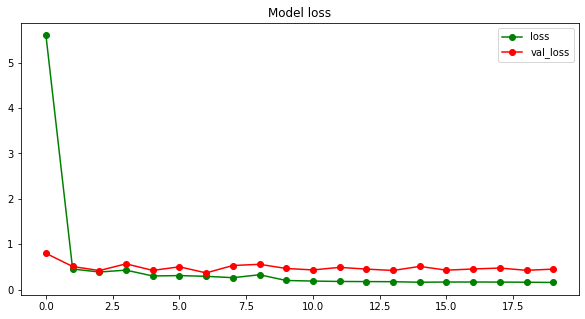

In [ ]:
plt.figure(figsize = (10, 5))
plt.title("Model loss")
plt.plot(history.history["loss"], "go-")
plt.plot(history.history["val_loss"], "ro-")
plt.legend(["loss", "val_loss"])
plt.show()

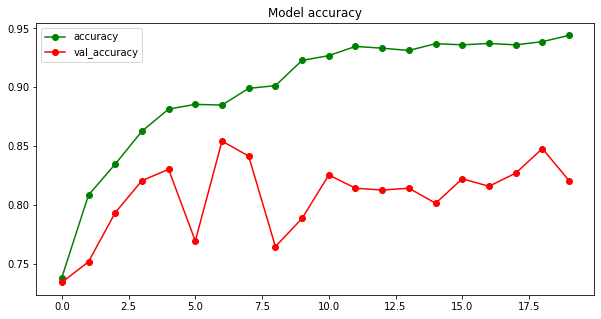

In [ ]:
plt.figure(figsize = (10, 5))
plt.title("Model accuracy")

plt.plot(history.history["accuracy"], "go-")
plt.plot(history.history["val_accuracy"], "ro-")
plt.legend(["accuracy", "val_accuracy"])
plt.show()

<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#4A1810; font-family:sans-serif;color:#FFFFFF;font-size:130%;text-align:center;border-radius:55px 1px;">Evaluate model1 on the test set </p>

In [ ]:
#scores = model1.evaluate_generator(test_set)
#print("\n%s: %.3f%%" % (model1.metrics_names[0], scores[0]*100))
#print("\n%s: %.3f%%" % (model1.metrics_names[1], scores[1]*100))

test_loss, test_accuracy = model1.evaluate(t_images_arr, t_labels_arr, steps = 50)
print("The testing accuracy is: ", test_accuracy * 100, "%")
print("The testing loss is: ", test_loss / 100)

50/50 [==============================] - 0s 5ms/step - loss: 0.7761 - accuracy: 0.8670
The testing accuracy is:  86.69871687889099 %
The testing loss is:  0.007761362791061401


In [ ]:
res, cnn_cm = evaluate_model("cnn_model", model1, t_images_arr, t_labels_arr)
res.head()


Model        cnn_model
Accuracy      0.866987
F1-Score      0.861136
Recall        0.866987
Precision     0.879465
dtype: object

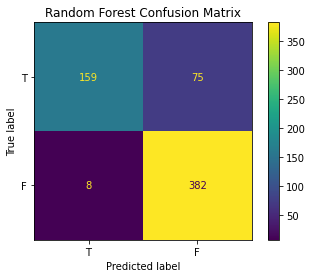

In [ ]:
class_labels = ["T","F"]
disp = ConfusionMatrixDisplay(confusion_matrix=cnn_cm, display_labels=class_labels)
disp.plot()
plt.title("Random Forest Confusion Matrix")
plt.savefig("Random Forest Confusion Matrix")
plt.show()

<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#4A1810; font-family:sans-serif;color:#FFFFFF;font-size:170%;text-align:center;border-radius:55px 1px;">TRANSFER LEARNING</p>

<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#4A1810; font-family:sans-serif;color:#FFFFFF;font-size:130%;text-align:center;border-radius:55px 1px;">MOBILENET model</p>

In [ ]:
# Neural network architecture
import tensorflow as tf

pretrainedModel = tf.keras.applications.MobileNet(
     input_shape = (224, 224, 3),
     include_top=False,
     weights='imagenet',
     pooling='avg'
)
pretrainedModel.trainable = False

inputs = pretrainedModel.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrainedModel.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model2 = tf.keras.Model(inputs=inputs, outputs=outputs)

optimizer_adam = tf.keras.optimizers.Adam(learning_rate = 0.005)

# Compile model
model2.compile(
    optimizer=optimizer_adam,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

17235968/17225924 [==============================] - 1s 0us/step


In [ ]:
import random

def shuffle_together(data, labels):
  """Shuffles two lists together while maintaining the corresponding order.

  Args:
      data: A list of data points.
      labels: A list of labels corresponding to the data points.

  Returns:
      A tuple containing the shuffled data and labels lists.
  """

  combined = list(zip(data, labels))
  random.shuffle(combined)
  shuffled_data, shuffled_labels = zip(*combined)
  return shuffled_data, shuffled_labels

# Example usage
shuffled_data, shuffled_labels = shuffle_together(list(train_data_arr), list(train_label_arr))
train_data_arr_ = np.asarray(shuffled_data)
train_label_arr_ = np.asarray(shuffled_labels)
#print(shuffled_data)
#print(shuffled_labels)


In [ ]:
%%time
'''
history = model2.fit_generator(datagen.flow(train_data_arr, train_label_arr, batch_size = 32), epochs = 10, validation_data=(t_images_arr, t_labels_arr), steps_per_epoch = 100,
                              )

history = model2.fit(train_data_arr, train_label_arr, batch_size = 64,
                    epochs = 10 ,
                    validation_data = (t_images_arr, t_labels_arr) ,
                    )#callbacks = [early_stopping_callbacks, learning_rate_reduction])

'''

history = model2.fit(datagen.flow(train_data_arr_f, train_label_arr_f, batch_size = 32),
                    epochs = 20 ,
                    validation_data = datagen.flow(t_images_arr, t_labels_arr) ,
                    callbacks = [early_stopping_callbacks, learning_rate_reduction])

Epoch 1/20
163/163 [==============================] - 77s 461ms/step - loss: 0.3288 - accuracy: 0.8635 - val_loss: 0.5491 - val_accuracy: 0.7612
Epoch 2/20
163/163 [==============================] - 75s 460ms/step - loss: 0.2254 - accuracy: 0.9015 - val_loss: 0.4426 - val_accuracy: 0.8269
Epoch 3/20
163/163 [==============================] - 75s 461ms/step - loss: 0.2019 - accuracy: 0.9183 - val_loss: 1.0244 - val_accuracy: 0.6490
Epoch 4/20
163/163 [==============================] - 74s 455ms/step - loss: 0.1589 - accuracy: 0.9344 - val_loss: 0.4926 - val_accuracy: 0.8189

Epoch 00010: ReduceLROnPlateau reducing learning rate to 4.049999843118712e-05.
Epoch 11/20
163/163 [==============================] - 74s 453ms/step - loss: 0.1578 - accuracy: 0.9356 - val_loss: 0.4642 - val_accuracy: 0.8301
Epoch 12/20
163/163 [==============================] - 75s 459ms/step - loss: 0.1640 - accuracy: 0.9340 - val_loss: 0.5156 - val_accuracy: 0.7933
Epoch 13/20
163/163 [==========================

<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#4A1810; font-family:sans-serif;color:#FFFFFF;font-size:130%;text-align:center;border-radius:55px 1px;">Visualize the performance of model 2</p>

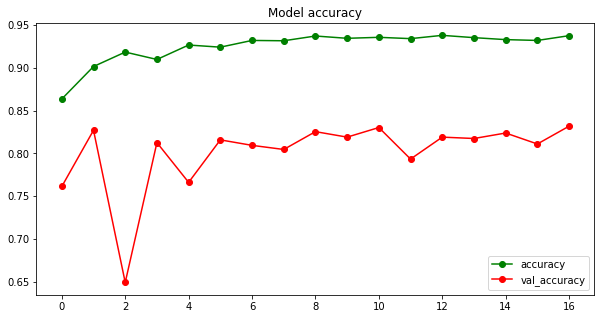

In [ ]:
plt.figure(figsize = (10, 5))
plt.title("Model accuracy")

plt.plot(history.history["accuracy"], "go-")
plt.plot(history.history["val_accuracy"], "ro-")
plt.legend(["accuracy", "val_accuracy"])
plt.show()

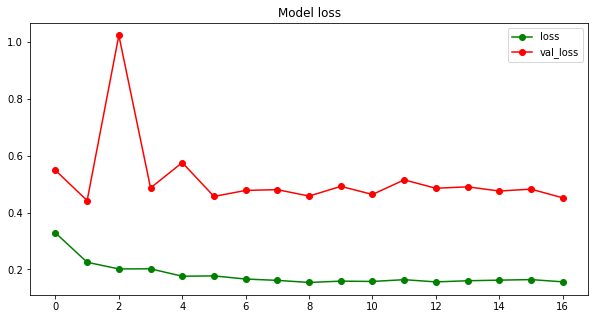

In [ ]:
plt.figure(figsize = (10, 5))
plt.title("Model loss")
plt.plot(history.history["loss"], "go-")
plt.plot(history.history["val_loss"], "ro-")
plt.legend(["loss", "val_loss"])
plt.show()

<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#4A1810; font-family:sans-serif;color:#FFFFFF;font-size:130%;text-align:center;border-radius:55px 1px;">Evaluate model 2 on the test set </p>

In [ ]:
#scores = model1.evaluate_generator(test_set)
#print("\n%s: %.3f%%" % (model1.metrics_names[0], scores[0]*100))
#print("\n%s: %.3f%%" % (model1.metrics_names[1], scores[1]*100))

test_loss, test_accuracy = model1.evaluate(t_images_arr, t_labels_arr, steps = 50)
print("The testing accuracy is: ", test_accuracy * 100, "%")
print("The testing loss is: ", test_loss * 100, "%")

50/50 [==============================] - 0s 5ms/step - loss: 0.7761 - accuracy: 0.8670
The testing accuracy is:  86.69871687889099 %
The testing loss is:  77.61362791061401 %


In [ ]:
res, mn_cm = evaluate_model("cnn_model", model1, t_images_arr, t_labels_arr)
res.head()


Model        cnn_model
Accuracy      0.866987
F1-Score      0.861136
Recall        0.866987
Precision     0.879465
dtype: object

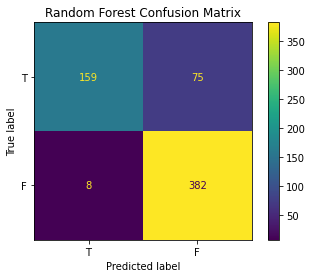

In [ ]:
class_labels = ["T","F"]
disp = ConfusionMatrixDisplay(confusion_matrix=mn_cm, display_labels=class_labels)
disp.plot()
plt.title("Random Forest Confusion Matrix")
plt.savefig("Random Forest Confusion Matrix")
plt.show()

<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#4A1810; font-family:sans-serif;color:#FFFFFF;font-size:130%;text-align:center;border-radius:55px 1px;">ResNet50V2 model</p>

In [ ]:
base_model2 = tensorflow.keras.applications.ResNet50V2(weights = "imagenet",
                                                       input_shape = (224, 224, 3),
                                                       pooling = "max", include_top = False,
                                                       classes = 2)

for layer in base_model2.layers:
    layer.trainable = False

#base_model2.summary()

94683136/94668760 [==============================] - 3s 0us/step


In [ ]:
model3 = Sequential()
model3.add(base_model2)
model3.add(Flatten())

model3.add(Dense(128, activation = "relu"))
model3.add(Dense(64, activation = "relu"))
model3.add(Dense(32, activation = "relu"))
model3.add(Dense(1, activation = "sigmoid"))

# freeze the layers
for layer in base_model2.layers:
    layer.trainable = False

model3.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

In [ ]:
%%time
"""
history = model3.fit_generator(train_set, epochs = 20, validation_data = validation_set, steps_per_epoch = 100,
                              callbacks = [early_stopping_callbacks])
"""
history = model3.fit(datagen.flow(train_data_arr_f, train_label_arr_f, batch_size = 32),
                    epochs = 20,
                    validation_data = datagen.flow(t_images_arr, t_labels_arr) ,
                    callbacks = [early_stopping_callbacks, learning_rate_reduction])

Epoch 1/20
163/163 [==============================] - 82s 482ms/step - loss: 6.0889 - accuracy: 0.7916 - val_loss: 1.7907 - val_accuracy: 0.8141
Epoch 2/20
163/163 [==============================] - 75s 459ms/step - loss: 1.4471 - accuracy: 0.8643 - val_loss: 1.2789 - val_accuracy: 0.8157
Epoch 3/20
163/163 [==============================] - 75s 460ms/step - loss: 0.9739 - accuracy: 0.8783 - val_loss: 1.0573 - val_accuracy: 0.8446
Epoch 4/20
163/163 [==============================] - 75s 458ms/step - loss: 1.1458 - accuracy: 0.8620 - val_loss: 1.1267 - val_accuracy: 0.8061
Epoch 5/20
163/163 [==============================] - 76s 465ms/step - loss: 0.4361 - accuracy: 0.8963 - val_loss: 0.7105 - val_accuracy: 0.8125

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 6/20
163/163 [==============================] - 75s 460ms/step - loss: 0.2963 - accuracy: 0.9147 - val_loss: 0.6099 - val_accuracy: 0.8221
Epoch 7/20
163/163 [=============================

<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#4A1810; font-family:sans-serif;color:#FFFFFF;font-size:130%;text-align:center;border-radius:55px 1px;">Visualize the performance of model 3</p>

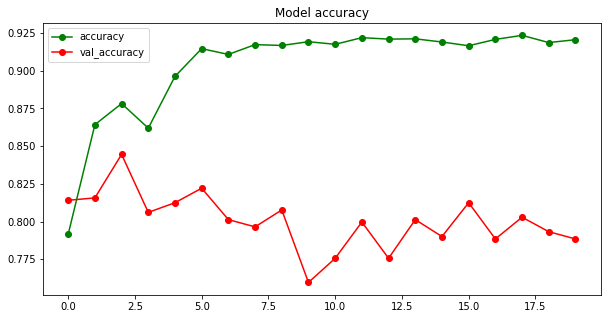

In [ ]:
plt.figure(figsize = (10, 5))
plt.title("Model accuracy")
plt.plot(history.history["accuracy"], "go-")
plt.plot(history.history["val_accuracy"], "ro-")
plt.legend(["accuracy", "val_accuracy"])
plt.show()

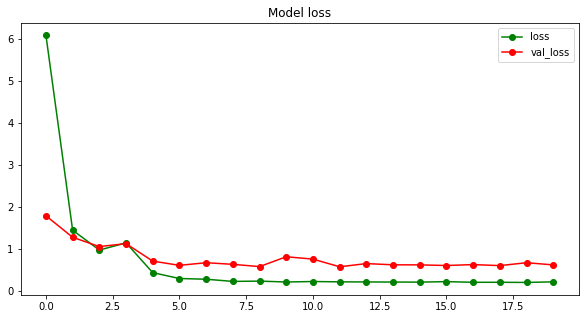

In [ ]:
plt.figure(figsize = (10, 5))
plt.title("Model loss")
plt.plot(history.history["loss"], "go-")
plt.plot(history.history["val_loss"], "ro-")
plt.legend(["loss", "val_loss"])
plt.show()

<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#4A1810; font-family:sans-serif;color:#FFFFFF;font-size:130%;text-align:center;border-radius:55px 1px;">Evaluate model 3 on the test set </p>

In [ ]:
#scores = model1.evaluate_generator(test_set)
#print("\n%s: %.3f%%" % (model1.metrics_names[0], scores[0]*100))
#print("\n%s: %.3f%%" % (model1.metrics_names[1], scores[1]*100))

test_loss, test_accuracy = model3.evaluate(t_images_arr, t_labels_arr, steps = 50)
print("The testing accuracy is: ", test_accuracy * 100, "%")
print("The testing loss is: ", test_loss * 100, "%")

50/50 [==============================] - 2s 24ms/step - loss: 0.3739 - accuracy: 0.8830
The testing accuracy is:  88.30128312110901 %
The testing loss is:  37.385496497154236 %


In [ ]:
res, vg_cm = evaluate_model("rn_model", model3, t_images_arr, t_labels_arr)
res.head()


Model        rn_model
Accuracy     0.883013
F1-Score       0.8823
Recall       0.883013
Precision    0.882408
dtype: object

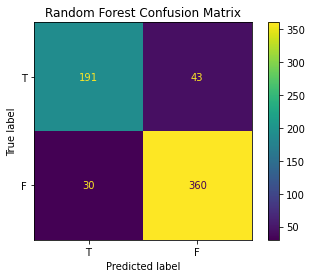

In [ ]:
class_labels = ["T","F"]
disp = ConfusionMatrixDisplay(confusion_matrix=vg_cm, display_labels=class_labels)
disp.plot()
plt.title("Random Forest Confusion Matrix")
plt.savefig("Random Forest Confusion Matrix")
plt.show()

<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#4A1810; font-family:sans-serif;color:#FFFFFF;font-size:130%;text-align:center;border-radius:55px 1px;">Using our trained model for Prediction</p>

In [ ]:
%%time

new_image_path = "/kaggle/input/pneumonia-lungs/download.jpg"
test_image = image.load_img(new_image_path, target_size = (224, 224))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
#test_image = np.reshape(test_image, (1, 224, 224, 3))
test_image = test_image / 255

#___________________________________________________________________

result = model1.predict(test_image)
#train_set.class_indices
if result[0][0] == 0:
    prediction = "N O R M A L"
else:
    prediction = "P N E U M O N I A"

print(prediction)

P N E U M O N I A
CPU times: user 43.1 ms, sys: 6.74 ms, total: 49.8 ms
Wall time: 49.2 ms


### Save the model to disk

In [ ]:
model1.save("cnn_pneumonia_detection_model.h5")
print(colored("Model3 was succesfully saved to disk...", color = "green", attrs = ["bold", "dark"]))

model2.save("mn_pneumonia_detection_model.h5")
print(colored("Model3 was succesfully saved to disk...", color = "green", attrs = ["bold", "dark"]))

model3.save("vg_pneumonia_detection_model.h5")
print(colored("Model3 was succesfully saved to disk...", color = "green", attrs = ["bold", "dark"]))

In [ ]:
model1.save("cnn_pneumonia_detection_model.h5")
print(colored("Model3 was succesfully saved to disk...", color = "green", attrs = ["bold", "dark"]))


### Some time later you may need that model to use

In [ ]:
model_loaded = tensorflow.keras.models.load_model("/kaggle/working/cnn_pneumonia_detection_model.h5")
model_loaded.summary()

### Use loaded model to predict new image

In [ ]:
from PIL import Image

def load_image(image_file):
    # Load image and apply preprocessing steps
    #img = cv2.resize(cv2.imread(image_file), (224,224))
    img = Image.open(image_file).convert('RGB')
    #img = img.resize((224, 224))
    return img

img = load_image("/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL/IM-0001-0001.jpeg")
test_image = np.asarray(img)
test_image = np.expand_dims(test_image, axis = 0)
test_image.shape

In [ ]:
def image_prediction(new_image_path):
    test_image = image.load_img(new_image_path, target_size = (224, 224))
    test_image = image.img_to_array(test_image)
    #test_image = np.reshape(test_image, (224, 224, 3))
    test_image = np.expand_dims(test_image, axis = 0)
    test_image = test_image / 255.0
    #model_loaded = tensorflow.keras.models.load_model("/kaggle/working/cnn_pneumonia_detection_model.h5")
    #prediction = model_loaded.predict(test_image)
    prediction = [0.87]
    test_image_for_plotting = image.load_img(new_image_path, target_size = (224, 224))
    plt.imshow(test_image_for_plotting)
    if(prediction[0] > 0.5):
        statistic = prediction[0] * 100
        print(statistic[0])
        print("This image is %.3f percent %s"% (statistic, "P N E U M O N I A"))
    else:
        statistic = (1.0 - prediction[0]) * 100
        print(statistic[0])
        print("This image is %.3f percent %s" % (statistic, "N O R M A L"))


def predict_pneumonia(image, sel_model):
    # We use our model to predict pneumonia and get probability
    test_image = np.asarray(image)
    test_image = np.expand_dims(test_image, axis = 0)
    prediction = sel_model.predict(test_image)
    if(prediction[0] > 0.5):
        statistic = prediction[0] * 100
        #print("This image is %.3f percent %s"% (statistic, "P N E U M O N I A"))
        return "P N E U M O N I A" , statistic
    else:
        statistic = (1.0 - prediction[0]) * 100
        #print("This image is %.3f percent %s" % (statistic, "N O R M A L"))
        return "N O R M A L" , statistic


In [ ]:
model_loaded = model1
image_prediction("/kaggle/input/pneumonia-lung-image-for-test/image.webp")

In [ ]:
# call and use the function
image_prediction("/kaggle/input/pneumonia-lung-image-for-test/image.webp")